In [ ]:
# use random over sampler to  resample training data (solve the problem of too skewed)

In [3]:
from statistics import mean,stdev
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc,recall_score,precision_score,f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string
import re
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
from nltk.stem.porter import *
stemmer = PorterStemmer()
filelist=os.listdir("/Users/veronica/Documents/research/standard")[1:]
path1 = "/Users/veronica/Documents/research/standard"
from imblearn.over_sampling import RandomOverSampler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def data_generate():
    sub=random.sample(range(1, 186), 15)
    frame1 = pd.DataFrame()
    list1 = []
    frame2 = pd.DataFrame()
    list2 = []
    for i in range(len(filelist)):
        df = pd.read_csv(os.path.join(path1, filelist[i]),encoding = 'unicode_escape', usecols = ['Sentence-String','Q2'])
        df['cleaned'] = df['Sentence-String'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x.split() if (str(i).isalpha() and i not in STOPLIST and len(i)>1)]).lower())
        if i in sub:
            list1.append(df)
        else:
            list2.append(df)
    frame1 = pd.concat(list1)
    frame2 = pd.concat(list2)
    Xtrain = frame2['cleaned']
    Xvalid = frame1['cleaned']
    Yvalid = np.array(frame1['Q2']) 
    Ytrain = np.array(frame2['Q2'])
    return(Xtrain,Xvalid,Ytrain,Yvalid)

def features_generate(X,tfidf_vect_ngram):
    x2=np.zeros(3)
    for sent in X:
        sents=" ".join([stemmer.stem(i) for i in sent.split()])
        flag=[]
        if ("random" in sents or 'randomli'in sents):
            flag.append(1)
        else :
            flag.append(0)
        if ("patient" in sents or "subject" in sents) and ("random" in sents or 'randomli'in sents):
            flag.append(1)
        else :
            flag.append(0)
        if ('alloc' in sents or "assign" in sents or 'gener' in sents) and ("random" in sents or 'randomli'in sents):
            flag.append(1)
        else :
            flag.append(0)
        x1 = np.array(flag)
        x2 = np.row_stack([x2,x1])
    x_tfidf =  tfidf_vect_ngram.transform(X)
    feature=np.delete(x2, 0, 0)
    x_features=np.c_[x_tfidf.toarray(),feature]
    return x_features 

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return predictions

In [63]:
Xtrain,Xvalid,Ytrain,Yvalid=data_generate()
tfidf_vect_ngram = TfidfVectorizer(ngram_range=(1, 2),max_features=10000)
tfidf_vect_ngram.fit(Xtrain)
xtrain_feature=features_generate(Xtrain,tfidf_vect_ngram)
xvalid_feature=features_generate(Xvalid,tfidf_vect_ngram)

In [66]:
rus =  RandomOverSampler()
X_res, y_res = rus.fit_sample(xtrain_feature, Ytrain)
preds=train_model(LinearSVC(C=0.4), X_res, y_res , xvalid_feature)

In [54]:
len(X_res)

57112

In [65]:
print(classification_report(Yvalid,preds))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2362
          1       0.30      0.54      0.38        24

avg / total       0.99      0.98      0.98      2386



In [41]:
def RUNSCV(x) :
    recall={}
    precision={}
    f1={}
    for i in x:
        recall[i]=[]
        precision[i]=[]
        f1[i]=[]
        
    tfidf_vect_ngram = TfidfVectorizer(ngram_range=(1, 2),max_features=10000)
    for k in range(10):
        Xtrain,Xvalid,Ytrain,Yvalid=data_generate()
        tfidf_vect_ngram.fit(Xtrain)
        xtrain_feature=features_generate(Xtrain,tfidf_vect_ngram)
        xvalid_feature=features_generate(Xvalid,tfidf_vect_ngram)
        for i in x:
            rus =  RandomOverSampler(i)
            X_res, y_res= rus.fit_sample(xtrain_feature, Ytrain)
            preds=train_model(LinearSVC(C=0.4), X_res, y_res , xvalid_feature)
            recall[i].append(recall_score(Yvalid, preds,average=None)[1])
            precision[i].append(precision_score(Yvalid, preds,average=None)[1])
            f1[i].append(f1_score(Yvalid, preds,average=None)[1])
    mrecall=[]
    mprecision=[]
    mf1=[]
    for i in x:
        mrecall.append(mean(recall[i]))
        mprecision.append(mean(precision[i]))
        mf1.append(mean(f1[i]))
    return(mprecision,mrecall,mf1)

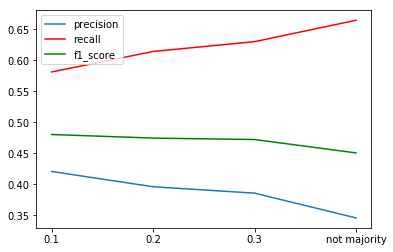

In [51]:
# choose the parameter for RandomOverSampler(i)
x=[0.1,0.2,0.3,'not majority']
mprecision,mrecall,mf1=RUNSCV(x) 
plt.plot(x,mprecision,label="precision")
plt.plot(x,mrecall,"r",label="recall") 
plt.plot(x,mf1,"g",label="f1_score") 
plt.legend()
plt.show()

In [6]:
##
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression 
names=["DecisionTree","MultinomialNB","LogisticRegression","LinearSVC","MLPClassifier"]
classifiers = [
    DecisionTreeClassifier(),
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(C=0.4),
    MLPClassifier()
    ]
def RUN_classifiers(classifiers,N) :
    tfidf_vect_ngram = TfidfVectorizer(ngram_range=(1, 2),max_features=10000)
    rus =  RandomOverSampler(0.1)
    recall={}
    precision={}
    f1={}
    for c in classifiers:
        recall[c]=[]
        precision[c]=[]
        f1[c]=[]
  
    for i in range(N):
        Xtrain,Xvalid,Ytrain,Yvalid=data_generate()
        tfidf_vect_ngram.fit(Xtrain)
        xtrain_feature=features_generate(Xtrain,tfidf_vect_ngram)
        xvalid_feature=features_generate(Xvalid,tfidf_vect_ngram)
        X_res, y_res= rus.fit_sample(xtrain_feature, Ytrain)
            
        for c in classifiers:
            preds=train_model(c, X_res, y_res , xvalid_feature)
            recall[c].append(recall_score(Yvalid, preds,average=None)[1])
            precision[c].append(precision_score(Yvalid, preds,average=None)[1])
            f1[c].append(f1_score(Yvalid, preds,average=None)[1])
            
    mrecall=[]
    mprecision=[]
    mf1=[]
    for c in classifiers:
        mrecall.append(mean(recall[c]))
        mprecision.append(mean(precision[c]))
        mf1.append(mean(f1[c]))
    
    return(mprecision,mrecall,mf1)




In [ ]:
mprecision,mrecall,mf1=RUN_classifiers(classifiers,5)

plt.plot(names,mprecision,label="precision")
plt.plot(names,mrecall,"r",label="recall") 
plt.plot(names,mf1,"g",label="f1_score") 
plt.annotate(round(max(mf1),3), xy=(names[np.argmax(mf1)], max(mf1)))
plt.legend()
plt.show()

In [5]:
import timeit
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression 


classifiers = [
    MLPClassifier(),
    KNeighborsClassifier(3),
    SVC()
    ]
def RUN_classifiers(classifiers) :
    recall=[]
    precision=[]
    f1=[]
    tfidf_vect_ngram = TfidfVectorizer(ngram_range=(1, 2),max_features=10000)
    rus =  RandomOverSampler(0.1)
    Xtrain,Xvalid,Ytrain,Yvalid=data_generate()
    tfidf_vect_ngram.fit(Xtrain)
    xtrain_feature=features_generate(Xtrain,tfidf_vect_ngram)
    xvalid_feature=features_generate(Xvalid,tfidf_vect_ngram)
    X_res, y_res= rus.fit_sample(xtrain_feature, Ytrain)
    for c in classifiers:
        start = timeit.default_timer()
        preds=train_model(c, X_res, y_res , xvalid_feature)
    
        print('Time: ', timeit.default_timer() - start)      
        print('precision:',precision_score(Yvalid, preds,average=None)[1],
              'recall:',recall_score(Yvalid, preds,average=None)[1],"f1:",f1_score(Yvalid, preds,average=None)[1])
    
    return(precision,recall,f1)


In [ ]:
precision,recall,f1=RUN_classifiers(classifiers) 

Time:  243.55711234300543
precision: 0.375 recall: 0.45 f1: 0.4090909090909091


In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    QuadraticDiscriminantAnalysis()]